In [2]:
import json
import pandas as pd
import numpy as np
from equipartition import Equipartition
import matplotlib.pyplot as plt

from astropy import units as u, constants as c

wtn_z = 0.049

# First, read in the files with the literature best-fit parameters

In [3]:
lit = pd.read_csv("lit_sed_params.csv", comment="#")
bhmasses = pd.read_csv("bh_masses_host.txt", sep="\t")
bhmasses["name"] = bhmasses.name.str.strip()

lit

,Name,t,p,epsilon_e,epsilon_B,nu_a,nu_a_error,nu_m,nu_m_error,Fp_mJy,Fp_mJy_error,dist_Mpc,z
0,CNSSJ0019+00,573,3.3,0.1,0.100,4.260000,0.040000,-99.990000,-99.990000,8.270000,0.030,77.1,0.0180
1,CNSSJ0019+00,606,3.3,0.1,0.100,3.870000,0.030000,-99.990000,-99.990000,8.080000,0.040,77.1,0.0180
2,CNSSJ0019+00,731,3.3,0.1,0.100,3.120000,0.040000,-99.990000,-99.990000,7.410000,0.060,77.1,0.0180
3,CNSSJ0019+00,998,3.3,0.1,0.100,1.920000,0.060000,-99.990000,-99.990000,4.950000,0.090,77.1,0.0180
4,ASASSN-14li,128,3.0,0.1,0.100,16.800000,0.000000,-99.990000,-99.990000,1.910000,0.000,90.0,0.0206
5,ASASSN-14li,143,3.0,0.1,0.100,8.200000,0.100000,-99.990000,-99.990000,1.760000,0.010,90.0,0.0206
6,ASASSN-14li,207,3.0,0.1,0.100,4.370000,0.200000,-99.990000,-99.990000,1.230000,0.030,90.0,0.0206
7,ASASSN-14li,246,3.0,0.1,0.100,4.000000,0.060000,-99.990000,-99.990000,1.140000,0.010,90.0,0.0206
8,ASASSN-14li,304,3.0,0.1,0.100,2.550000,0.060000,-99.990000,-99.990000,0.940000,0.020,90.0,0.0206
9,ASASSN-14li,381,3.0,0.1,0.100,1.910000,0.070000,-99.990000,-99.990000,0.620000,0.020,90.0,0.0206


# Now, use the Equipartition class to compute physical properties of the system

In [11]:
# need to compute
# Req, energyeq, magField, Ne, CNMnumDens and betaeqN

# first clean up the data
eq_data = {
    "name":[],
    "F_p":[],
    "nu_p":[],
    "p":[],
    "t":[],
    "z":[],
    "nu_m":[],
    "nu_a":[]
}
nsamples = 1_000
for name, grp in lit.groupby("Name"):
    for _,row in grp.iterrows():
        if row.nu_a > row.nu_m:
            nu_p_key = "nu_a"
        else:
            nu_p_key = "nu_m"
        
        eq_data["name"].append(name)
        eq_data["nu_p"].append(
            np.random.normal(row[nu_p_key]/10, row[nu_p_key+"_error"]/10, nsamples)
        )
        eq_data["F_p"].append(
            np.random.normal(row["Fp_mJy"], row["Fp_mJy_error"], nsamples)
        )
        eq_data["t"].append(row.t)
        eq_data["z"].append(row.z)
        eq_data["p"].append(row.p)
        eq_data["nu_m"].append(
            np.random.normal(row.nu_m/10, row.nu_m_error/10, nsamples)
            if row.nu_m not in {-99.99, 0} 
            else np.array([0]*nsamples)
        )
        eq_data["nu_a"].append(
            np.random.normal(row.nu_a/10, row.nu_a_error/10, nsamples)
            if row.nu_a not in {-99.99, 0} 
            else np.array([1]*nsamples)
        )


# then do the computations
res = []
for name, grp in pd.DataFrame(eq_data).groupby("name"):

    for _,row in grp.iterrows():
        if name == "SwJ1644+57":
            # then this is an on-axis jet
            eq = Equipartition(
                row.F_p,
                row.nu_p,
                row.t,
                z = row.z,
                nuA10 = row.nu_a,
                nuM10 = row.nu_m,
                theta = 0,
                p=row.p,
                epse=0.1, 
                fOmega=1, # for relativistic on-axis jet
                fA=1, # for relativistic on-axis jet
                fV=1, # for relativistic on-axis jet
                newtonian=False, 
                onAxis=True,
                isoNewtonianNe=False,
                corr=True, 
                outofequipartition=False, 
                factorsFour=True,
                hotprotons=True
            )
        else:
            eq = Equipartition(
                row.F_p,
                row.nu_p,
                row.t,
                z = row.z,
                # nuA10 = row.nu_a, # we don't need the energy correction in these cases
                # nuM10 = row.nu_m, # we don't need the energy correction in these cases
                theta = 0,
                p=row.p,
                epse=0.1, 
                fOmega=4,
                fA=1, 
                fV=0.36, 
                newtonian=True, 
                isoNewtonianNe=True,
                corr=True, 
                outofequipartition=False, 
                factorsFour=True,
                hotprotons=True
            )

        for key, func in {
            "gammabeta":eq.gammaBeta, 
            "Req":eq.Req, 
            "Eeq":eq.energyeq, 
            "B":eq.magField, 
            "Ne":eq.Ne, 
            "number_density":eq.CNMnumDens
        }.items():
            row[key+"_all"] = func()
            row[key] = np.nanmean(row[key+"_all"])
            row[key+"_err"] = np.nanstd(row[key+"_all"])    
        res.append(row)

eq_res = pd.DataFrame(res)

/home/nfranz/research/equipartition/equipartition/equipartition.py:237: RuntimeWarning: invalid value encountered in power
  return (self.xi**(1/(2 * pb + 13)) * self.eps()**(1/(2 * pb + 13)) * self.chie()**((2 - pb)/(2 * pb + 13)) * (pb + 1)**(1/(2 * pb + 13)) * self.C()**((pb + 5)/(2 * pb + 13)) * self.c_cgs**(1/(2 * pb + 13)) * self.Fp**((pb + 6)/(2 * pb + 13)) * self.dL**(2 * (pb + 6)/(2 * pb + 13)) * self.eta()**(5/3 * (pb + 5)/(2 * pb + 13)))/\
/home/nfranz/research/equipartition/equipartition/equipartition.py:230: RuntimeWarning: invalid value encountered in power
  return (self.xi**(1/(2 * pb + 13)) * self.eps()**(1/(2 * pb + 13)) * self.gammaM()**((2 - pb)/(2 * pb + 13)) * (pb + 1)**(1/(2 * pb + 13)) * self.C()**((pb + 5)/(2 * pb + 13)) * self.c_cgs**(1/(2 * pb + 13)) * self.Fp**((pb + 6)/(2 * pb + 13)) * self.dL**(2 * (pb + 6)/(2 * pb + 13)) * self.eta()**(5/3 * (pb + 5)/(2 * pb + 13)))/\
/home/nfranz/research/equipartition/equipartition/equipartition.py:230: RuntimeWarning: 

In [12]:
eq_res

,name,F_p,nu_p,p,t,z,nu_m,nu_a,gammabeta_all,gammabeta,...,Eeq_err,B_all,B,B_err,Ne_all,Ne,Ne_err,number_density_all,number_density,number_density_err
0,ASASSN-14li,"[1.91, 1.91, 1.91, 1.91, 1.91, 1.91, 1.91, 1.9...","[1.6800000000000002, 1.6800000000000002, 1.680...",3.0,128,0.0206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.6800000000000002, 1.6800000000000002, 1.680...","[0.0313797988823475, 0.0313797988823475, 0.031...",0.031380,...,3.245186e+32,"[2.919501153655936, 2.919501153655936, 2.91950...",2.919501,0.000000,"[1.4429917351198423e+52, 1.4429917351198423e+5...",1.442992e+52,0.000000e+00,"[3252.057484615242, 3252.057484615242, 3252.05...",3252.057485,4.547474e-13
1,ASASSN-14li,"[1.7618891103631946, 1.7731287471826302, 1.754...","[0.8100927496470021, 0.8375733177077879, 0.807...",3.0,143,0.0206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8172407185889736, 0.8341402927643228, 0.816...","[0.056065244590608104, 0.05438934217483087, 0....",0.055347,...,2.447118e+46,"[1.4197899354272432, 1.4669708242338801, 1.415...",1.437950,0.016864,"[2.713961154280588e+52, 2.645200820528994e+52,...",2.677545e+52,3.657527e+50,"[769.1111328766619, 821.0769574079968, 764.318...",789.020196,1.850020e+01
2,ASASSN-14li,"[1.1972650470501163, 1.3117712110276942, 1.295...","[0.4462993060198874, 0.42409460502919677, 0.40...",3.0,207,0.0206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4311907961513358, 0.41150418809480394, 0.44...","[0.05854493037766976, 0.06433432728715736, 0.0...",0.060561,...,1.227772e+47,"[0.8146620437818497, 0.7667229476102575, 0.734...",0.797009,0.037385,"[3.0860293181909704e+52, 3.6272911550937463e+5...",3.255827e+52,1.835061e+51,"[253.21875908015318, 224.29409221452522, 206.0...",242.896856,2.270243e+01
3,ASASSN-14li,"[1.1520487174266352, 1.1546409225427807, 1.135...","[0.4017338856717041, 0.40561501920197124, 0.40...",3.0,246,0.0206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.3996327203140522, 0.40602044074136506, 0.40...","[0.053739365518047845, 0.05328185492763094, 0....",0.053746,...,3.898902e+46,"[0.7362913177004378, 0.7432287385781643, 0.739...",0.733573,0.010794,"[3.2722648596137675e+52, 3.24978389359013e+52,...",3.248016e+52,5.827401e+50,"[206.84273422353678, 210.75888866831428, 208.6...",205.362965,6.042295e+00
4,ASASSN-14li,"[0.9502153318054317, 0.9905135451437669, 0.934...","[0.26577721257348225, 0.244795289260008, 0.254...",3.0,304,0.0206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.25275319614434394, 0.2538358007954726, 0.24...","[0.06000005659410955, 0.06643712713250419, 0.0...",0.062233,...,9.426263e+46,"[0.49708893299750806, 0.45584860567423063, 0.4...",0.477338,0.011186,"[3.917509734731334e+52, 4.4726067056696164e+52...",4.027348e+52,1.408874e+51,"[94.27772626017351, 79.28338295011405, 86.6162...",86.982301,4.080454e+00
5,ASASSN-14li,"[0.6034509489344899, 0.5826343698475899, 0.632...","[0.18747184244637816, 0.1813440749120899, 0.18...",3.0,381,0.0206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.19341329551807634, 0.18744495875996828, 0.1...","[0.054736986261326157, 0.055653416381141796, 0...",0.054497,...,1.147925e+47,"[0.3677970107777528, 0.35709218596663694, 0.36...",0.373508,0.013788,"[3.205532088840882e+52, 3.175976453311169e+52,...",3.254975e+52,1.715719e+51,"[51.61278592913085, 48.65210161355779, 51.6938...",53.300567,3.928332e+00
6,AT2018hyz,"[2.52013668802139, 2.9299176356595136, 1.64830...","[0.14770548190179014, 0.15264385879225278, 0.1...",2.3,972,0.0457,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.18492859914361184, 0.1514933788423416, 0.17...","[0.08692120512500864, 0.0903025116636922, 0.05...",0.078107,...,3.880187e+48,"[0.14124652912065758, 0.14349115466399515, 0.1...",0.155940,0.017750,"[3.299609647064425e+53, 3.8183833606873777e+53...",2.861800e+53,5.831759e+52,"[8.594407296802128, 8.86973455562333, 15.84741...",10.611305,2.379401e+00
7,AT2018hyz,"[4.962624117249396, 4.938956511693276, 4.92690...","[0.151717490345

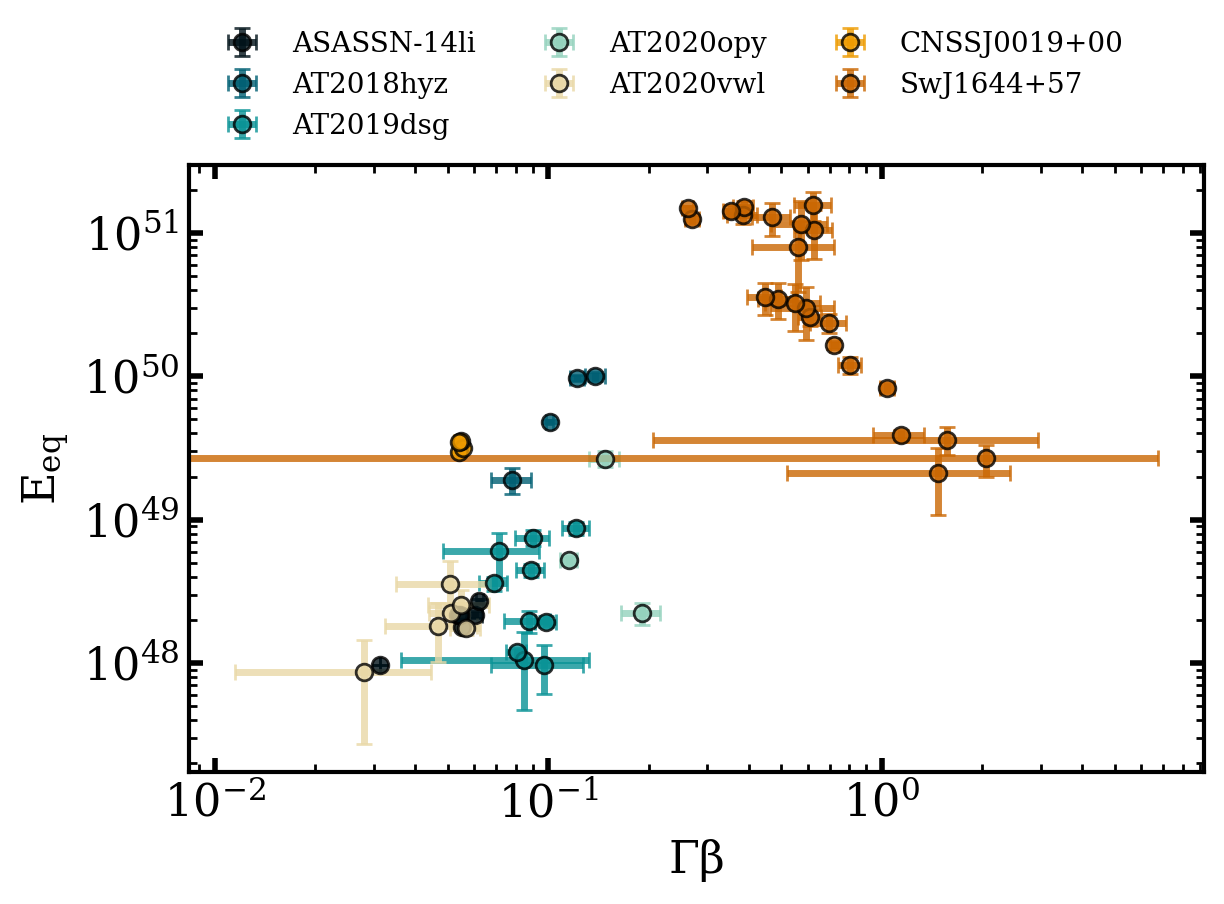

In [13]:
# energy vs gammabeta plot
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("name"):
    ax.errorbar(
        grp.gammabeta,
        grp.Eeq,
        xerr = grp.gammabeta_err,
        yerr = grp.Eeq_err,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$E_{eq}$")
ax.set_xlabel(r"$\Gamma \beta$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

ASASSN-14li
AT2018hyz
AT2019dsg
AT2020opy
AT2020vwl
CNSSJ0019+00
SwJ1644+57


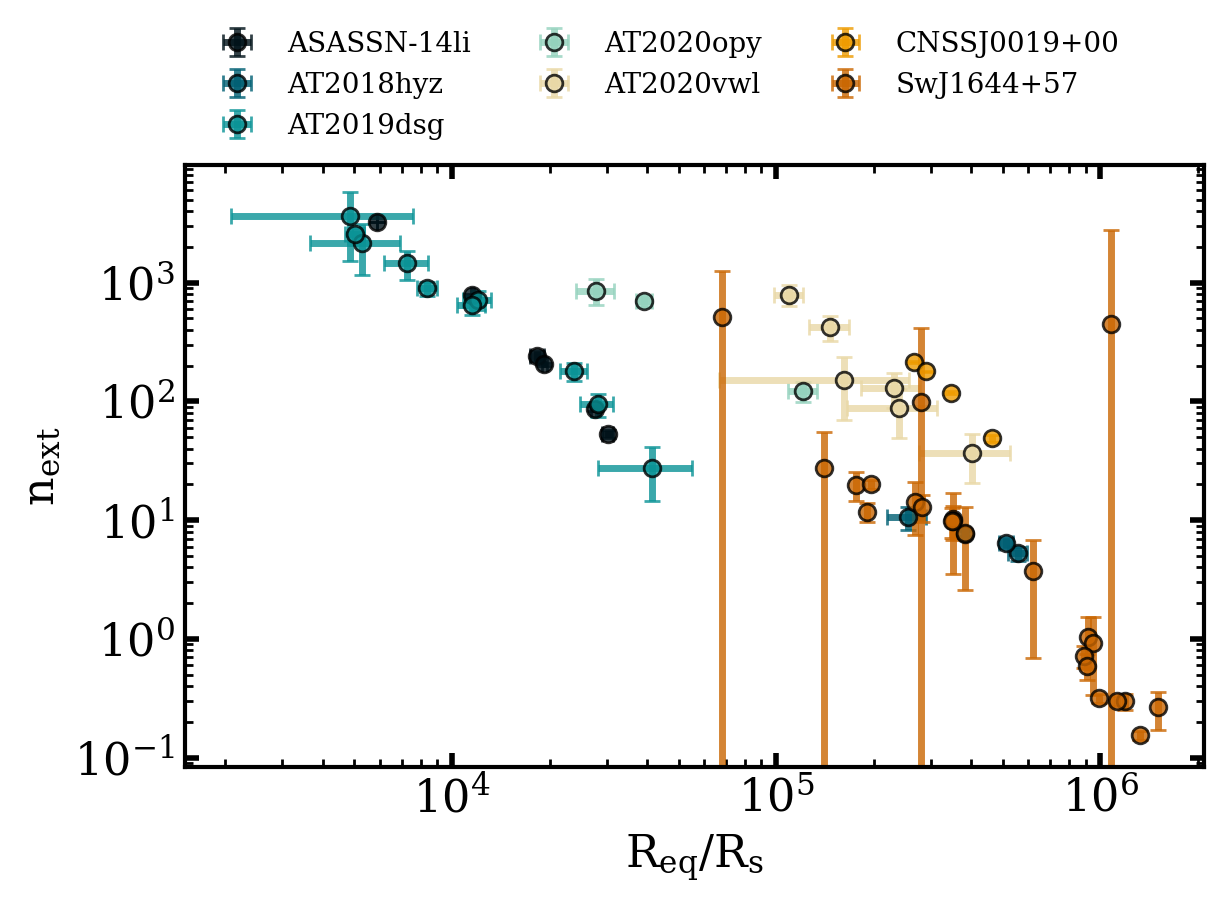

In [14]:
# density vs. radius
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("name"):
    print(name)
    Mbh = 10**(bhmasses[bhmasses.name == name].bhmass.values[0]) * u.M_sun
    Mbh_err = 10**(bhmasses[bhmasses.name == name].bhmass_err.values[0]) * u.M_sun
    Rs = (2*c.G*Mbh / c.c**2).cgs.value
    Rs_err = (2*c.G*Mbh_err / c.c**2).cgs.value
    ax.errorbar(
        grp.Req/Rs,
        grp.number_density,
        xerr = np.sqrt( (grp.Req_err/Rs)**2 + (Rs_err/Rs)**2 ),
        yerr = grp.number_density_err,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$n_{ext}$")
ax.set_xlabel(r"$R_{eq} / R_{s}$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

In [8]:
eq_res[[c for c in eq_res.columns if "_all" not in c and c not in {"F_p", "nu_p", "nu_m", "nu_a"}]].to_csv("equipartition-results.csv")